In [27]:
import os
import glob
import random

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from itertools import chain

In [28]:
# model_name = "resnet"
model_name = "fdcgan"
dataset_name = "apple2orange64"

Samples of dataset A


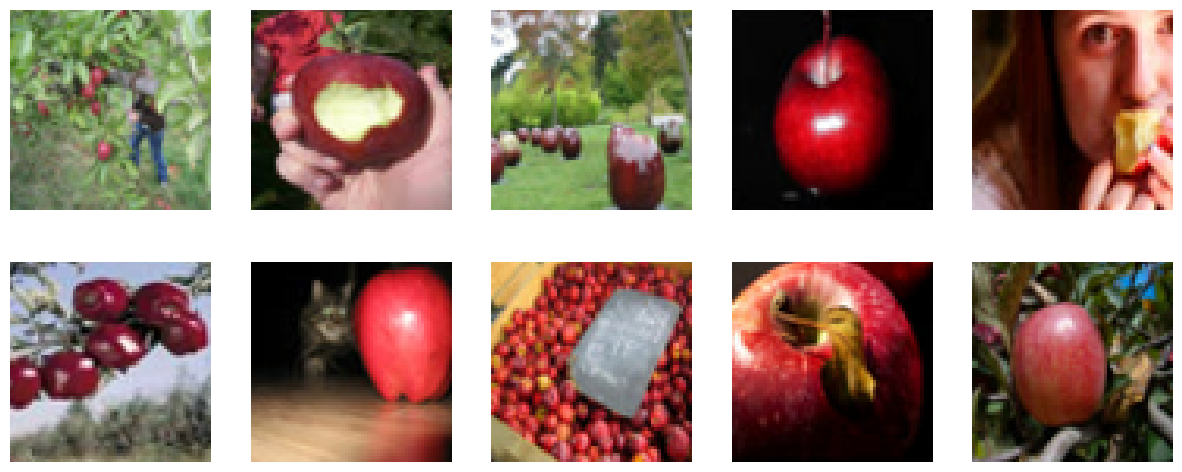

Samples of dataset B


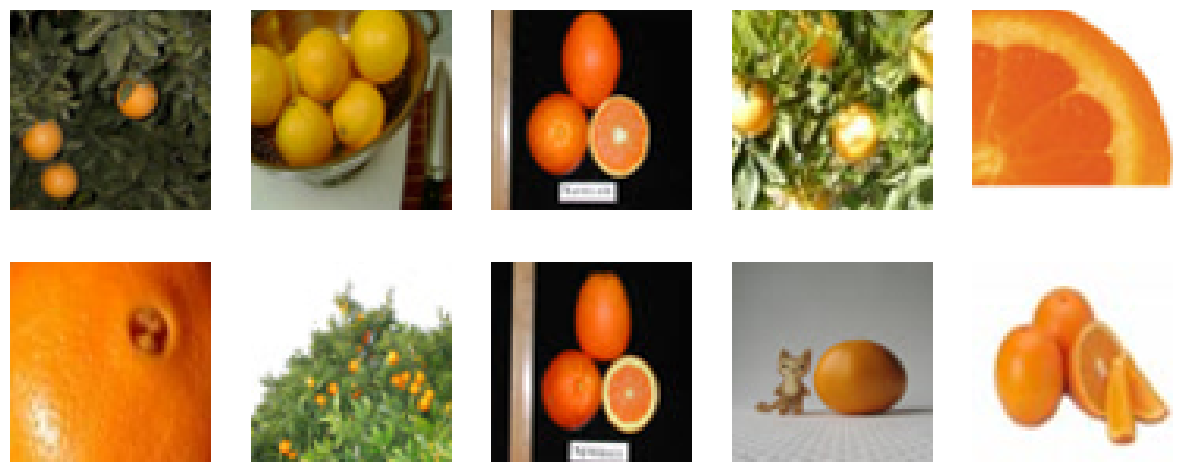

In [29]:
# --- Extract data from local files

class ImageClass(Dataset):
    def __init__(self, root, transformations, mode="train", image_class="A"):
        self.transform = transforms.Compose(transformations)

        dir_path = os.path.join(root, mode, image_class)
        if not os.path.exists(dir_path):
            raise FileNotFoundError(f"Directory not found : {dir_path}")
        self.files = sorted(glob.glob(os.path.join(dir_path, "*.*")))

    def __getitem__(self, index):
        return self.transform(Image.open(self.files[index]))

    def __len__(self):
        return len(self.files)

data_path = os.path.join(".", "datasets", dataset_name)
img_size = 64
img_shape = (3, img_size, img_size)

transformations = [
    transforms.Resize(int(img_size * 1.12), Image.BICUBIC),
    transforms.RandomCrop((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

dataset_a = ImageClass(data_path, transformations, mode="validation", image_class="A")
dataset_b = ImageClass(data_path, transformations, mode="validation", image_class="B")

def tensor_to_image(tensor_image):
    image = tensor_image.detach().to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    return image

def show_sample(dataset):
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    for i, j in enumerate(random.sample(range(len(dataset)), 10)):
        img = dataset[j]
        ax = axs[i // 5, i % 5]
        ax.imshow(tensor_to_image(img))
        ax.axis("off")
    plt.show()

print("Samples of dataset A")
show_sample(dataset_a)

print("Samples of dataset B")
show_sample(dataset_b)

In [30]:
# --- Load the pretrained CycleGan generator

model_save_dir = os.path.join(".", "saved_models", "cycle-gan", model_name, dataset_name)

if model_name == "fdcgan":
    from fdcgan import Generator
    g_ab = Generator(img_shape)
    g_ba = Generator(img_shape)

elif model_name == "resnet":
    from resnet import Generator
    g_ab = Generator(img_shape, num_residual_blocks=9)
    g_ba = Generator(img_shape, num_residual_blocks=9)

else:
    raise ValueError("Invalid model name")

g_ab_save_path = os.path.join(model_save_dir, "G_AB_199.pth")
g_ba_save_path = os.path.join(model_save_dir, "G_BA_199.pth")

if not os.path.exists(g_ab_save_path):
    raise FileNotFoundError(f"Could not find the pretrained model: {g_ab_save_path}")
elif not os.path.exists(g_ba_save_path):
    raise FileNotFoundError(f"Could not find the pretrained model: {g_ba_save_path}")
else:
    print(f"Loading pretrained models:\nA->B: {g_ab_save_path}\nB->A: {g_ba_save_path}")

g_ab.load_state_dict(torch.load(g_ab_save_path))
g_ba.load_state_dict(torch.load(g_ba_save_path))

g_ab.eval()
g_ba.eval()

Loading pretrained models:
A->B: ./saved_models/cycle-gan/fdcgan/apple2orange64/G_AB_199.pth
B->A: ./saved_models/cycle-gan/fdcgan/apple2orange64/G_BA_199.pth


Generator(
  (conv_blocks): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Tanh()
  )
)

In [31]:
# --- Translate all the images of the test dataset into images of the other class

with torch.no_grad():
    original_a = next(iter(DataLoader(dataset_a, batch_size=len(dataset_a), shuffle=False)))
    recovered_a = g_ba(g_ab(original_a))

    original_b = next(iter(DataLoader(dataset_b, batch_size=len(dataset_b), shuffle=False)))
    recovered_b = g_ba(g_ab(original_b))

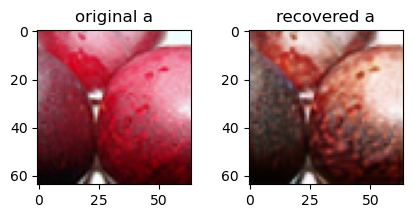

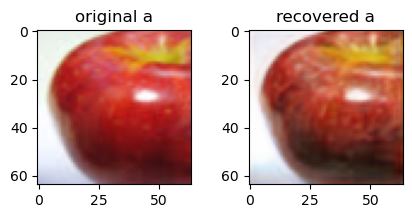

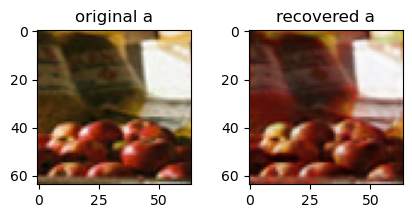

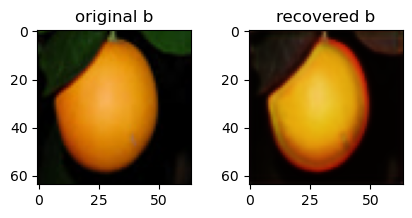

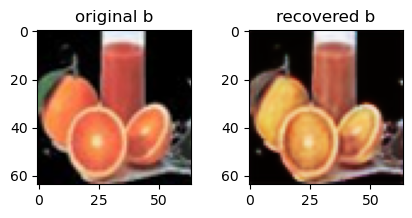

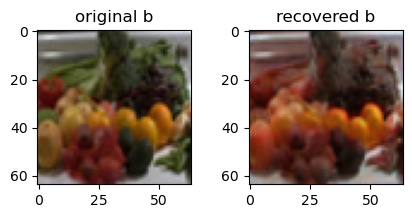

In [32]:
# --- Show samples of the images and their recovering

for i in random.sample(range(len(original_a)), 3):
    origin = original_a[i]
    recov = recovered_a[i]

    fig, axis = plt.subplots(1, 2, figsize=(5, 2))
    axis[0].set_title("original a")
    axis[0].imshow(tensor_to_image(origin))
    axis[1].set_title("recovered a")
    axis[1].imshow(tensor_to_image(recov))

for i in random.sample(range(len(original_b)), 3):
    origin = original_b[i]
    recov = recovered_b[i]

    fig, axis = plt.subplots(1, 2, figsize=(5, 2))
    axis[0].set_title("original b")
    axis[0].imshow(tensor_to_image(origin))
    axis[1].set_title("recovered b")
    axis[1].imshow(tensor_to_image(recov))

In [43]:
# --- Compute the PSNR value

def compute_psnr(original_images, recoverd_images):
    assert len(original_images) == len(recoverd_images)
    total_psnr = 0.
    for origin, recov in zip(original_images, recoverd_images):
        total_psnr += 10. * torch.log10(
            (img_size * img_size) / ((origin - recov).norm(2) ** 2)
        )
    return total_psnr / len(original_images)

with torch.no_grad():
    psnr_a = compute_psnr(original_a, recovered_a)
    psnr_b = compute_psnr(original_b, recovered_b)

print(psnr_a)
print(psnr_b)

tensor(12.6546)
tensor(12.4065)
